In [1]:
#Script: Tutorial for generating the mutation classification plot
#Author: Somnath Tagore, Ph.D.
#Date of Creation: 02/24/2025

#Note: The following tutorial classifies the VUFS into GOF, LOF, NEU, NEO.
#Note: It requires two inputs, a) the consensus signature, b) VUFS matrix


In [2]:
# load packages
library(viper)
library(ggplot2)
library(RColorBrewer)
library(dplyr)
library(ggrepel)

# set analysis seed
set.seed(1)

Loading required package: Biobase

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.



Attaching package: ‘dplyr’


The following object is masked from ‘package:Biobase’:

    combine


The following objects are masked from ‘packag

In [3]:
#input consensus signature (GOF/LOF)
ref.sig <- readRDS("../../PIK3CA_BLCA/consensus_signature_pik3ca_blca.rds")
ref.sig <- ref.sig[,1]

#input VUFS viper matrix
test.vpmat <- readRDS("../../PIK3CA_BLCA/blca.pik3ca.VUFS.vpmat.rds")
#head(test.vpmat)

[1] 2353   37

In [4]:
# subset the test protein activity matrix to only proteins included in the consensus protein activity signature
common.proteins <- intersect(names(ref.sig),rownames(test.vpmat))
test.vpmat <- test.vpmat[match(common.proteins,rownames(test.vpmat)),]
ref.sig <- ref.sig[match(common.proteins,names(ref.sig))]
identical(rownames(test.vpmat),names(ref.sig))


[1] TRUE

In [5]:
# create a synthetic regulon with the top 50 and bottom 50 proteins from the consensus protein activity signature
ref.regul <- c(sort(ref.sig,decreasing = TRUE)[1:50],rev(sort(ref.sig,decreasing = FALSE)[1:50]))
ref.regul <- list(tfmode = ref.regul/abs(ref.regul), likelihood = as.numeric(ref.regul/ref.regul))

# compute the enrichment of the synthetic regulon in all samples in the test protein activity matrix using aREA
test.enrichment.values <- aREA(eset = test.vpmat, regulon = list(Ref = ref.regul))$nes[1,]


In [6]:
# order the samples in the protein activity matrix by their enrichment and the rows by the protein activity in the consensus signature
sample.sort <- names(sort(test.enrichment.values,decreasing = TRUE))
protein.sort <- names(sort(ref.sig,decreasing = TRUE))



In [7]:
# subset to only the top 50 and bottom 50 proteins from the consensus signature
plot.data <- test.vpmat[match(protein.sort,rownames(test.vpmat)),match(sample.sort,colnames(test.vpmat))]
plot.data <- plot.data[match(names(ref.regul$tfmode),rownames(plot.data)),]


In [8]:
# create one-tailed regulons from each of the unknown samples top 50 and bottom 50 proteins
plot.data <- test.vpmat[match(protein.sort,rownames(test.vpmat)),match(sample.sort,colnames(test.vpmat))]

unknown.interactome <- lapply(colnames(plot.data),function(cur.sample){
  cur.sig <- plot.data[,match(cur.sample,colnames(plot.data))]
  cur.regul <- c(sort(cur.sig,decreasing = TRUE)[1:50],rev(sort(cur.sig,decreasing = FALSE)[1:50]))
  cur.regul <- list(tfmode = 0.001*cur.regul/abs(cur.regul), likelihood = as.numeric(cur.regul/cur.regul))
})
names(unknown.interactome) <- colnames(plot.data)
class(unknown.interactome) <- "regulon"
unknown.interactome



Object of class regulon with 37 regulators, 739 targets and 3700 interactions

In [9]:
# compute the enrichment of the one-tailed unknown regulons in the inverted consensus protein activity signature
inverted.ref.sig <- 1/ref.sig
inverted.enrichment.values <- aREA(eset = inverted.ref.sig, regulon = unknown.interactome)$nes[,1]


[1] TRUE

Warning message:
“Removed 1 rows containing missing values (`geom_hline()`).”


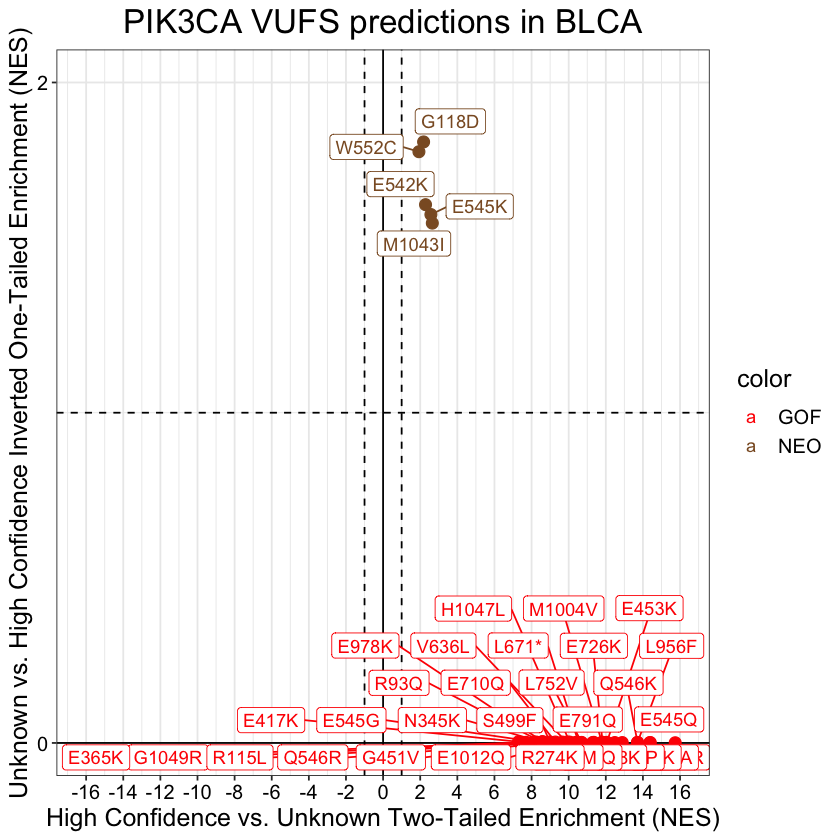

In [12]:
# plot the original enrichment values vs. the inverted enrichment values (as a neomorph plot)
x.values <- inverted.enrichment.values
y.values <- test.enrichment.values
y.values <- y.values[match(names(x.values),names(y.values))]
identical(names(x.values),names(y.values))

plot.data <- data.frame(x.values,y.values)
plot.data$x.padj <- p.adjust(p = pnorm(plot.data$x.values,lower.tail = FALSE),method = "BH")
plot.data$y.padj <- p.adjust(p = 2*pnorm(abs(plot.data$y.values),lower.tail = FALSE),method = "BH")

plot.data$color <-"NEU"
plot.data[which(plot.data$y.values < 0),"color"] <- "LOF"
plot.data[which(plot.data$y.values > 0),"color"] <- "GOF"
plot.data[which(plot.data$y.values > 1 & ( plot.data$x.values > 1 | plot.data$x.values < -1) )  ,"color"] <-"NEO"
plot.data[which(plot.data$y.values < 1 & ( plot.data$x.values > 1 | plot.data$x.values < -1))  ,"color"] <-"NEO"
plot.data[which(between(plot.data$y.values, -1, 1) & (plot.data$y.padj > 0.05 | plot.data$x.padj > 0.05) ) ,"color"] <- "NEU"
plot.data[which(between(plot.data$y.values, -1, 1) & between(plot.data$x.values, -1, 1) & (plot.data$y.padj > 0.05 | plot.data$x.padj > 0.05) ) ,"color"] <- "NEU"

plot.data$Label <- sapply(rownames(plot.data),function(x){return(x[1])})
#write.csv(plot.data,'plot.data.csv')

plot.data <- read.csv('plot.data.csv')
colour.value.vec <- c("NEU" = "grey50", "LOF" = "blue", "GOF" = "red1", "NEO" = "tan4", "NEO" = "limegreen")
shape.value.vec <- c("NEU" = 17,"LOF" = 17,"GOF" = 17,"NEO" = 17,"NEO" = 17)


# Define axis limits
y.step <- 2
y.max <- y.step * ceiling(max(abs(plot.data$y.values)) / y.step)
y.min <- -1 * y.max

x.step <- 2
x.max <- x.step * ceiling(max(abs(plot.data$x.values)) / x.step)
x.min <- 0

# Create plot
ggplot(plot.data, aes(x = y.values, y = x.values, color = color)) +
  geom_hline(colour = "black", lwd = .5, yintercept = 0) +
  geom_vline(colour = "black", lwd = .5, xintercept = 0) +
  geom_hline(colour = "black", lwd = .5, yintercept = c(1, -1), linetype="dashed") +
  geom_vline(colour = "black", lwd = .5, xintercept = c(-1, 1), linetype="dashed") +
  geom_point(size = 3) +
  theme_bw() +
  scale_colour_manual(values = colour.value.vec, labels = plot.data$color) +
  scale_shape_manual(values = shape.value.vec) +
  scale_y_continuous(limits = c(x.min, x.max), breaks = seq(from = x.min, to = x.max, by = x.step)) +
  scale_x_continuous(limits = c(y.min, y.max), breaks = seq(from = y.min, to = y.max, by = y.step)) +
  labs(
    title = "PIK3CA VUFS predictions in BLCA",
    x = "High Confidence vs. Unknown Two-Tailed Enrichment (NES)",
    y = "Unknown vs. High Confidence Inverted One-Tailed Enrichment (NES)"
  ) +
  theme(
    plot.title = element_text(hjust = 0.5, colour = "black", size = 20),
    plot.subtitle = element_text(hjust = 0.5, colour = "black", size = 18),
    axis.title = element_text(hjust = 0.5, colour = "black", size = 15),
    axis.text = element_text(hjust = 0.5, colour = "black", size = 12),
    legend.title = element_text(colour = "black", size = 15),
    legend.text = element_text(colour = "black", size = 12)
  ) +
  geom_label_repel(aes(label = Label), max.overlaps = Inf)
#ggsave("neomorph_pik3ca_blca.v2.pdf",width=10,height = 10)
